## Analysis of cloting images using an Machine Learning and Deep Learning models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.datasets import fashion_mnist as dataset
from pprint import pprint

In [2]:
(X_train,y_train),(X_test,y_test)=dataset.load_data()

In [115]:
CLASS_NAMES = {0: "T-shirt/top",
               1: "Trousers",
               2: "Pullover",
               3: "Dress",
               4: "Coat",
               5: "Sandal",
               6: "Shirt",
               7: "Sneaker",
               8: "Bag",
               9: "Ankle boot"}

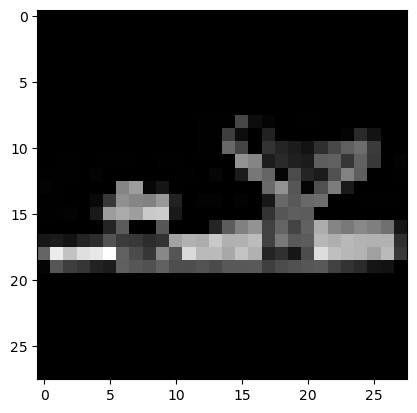

In [4]:
index = -1
image=X_train[index,:,:] # this assigns the last image (index 1) with all pixels in the matrix (:,:) 

plt.imshow(image,cmap='gray')
plt.show()

In [5]:
print(f"The last instance in y_train is label: {y_train[index]}, {CLASS_NAMES[y_train[index]]}")

The last instance in y_train is label: 5, Sandal


In [6]:
X_train_df = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],-1))) # reshaping X_train to 2d array and putting in DataFrame
X_test_df = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],-1))) # reshaping X_test to 2d array and putting in DataFrame
y_train_df = pd.DataFrame(y_train) #changing np.array to pd DataFrame
y_test_df = pd.DataFrame(y_test) #changing np.array to pd DataFrame

Looking at training data matrix where numbers relay the coloring

In [7]:
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,66,54,50,5,0,1,0,0,0,0


In [8]:
X = pd.concat([X_train_df, X_test_df], axis=0).reset_index()
X.columns = ['feature_' + str(i) for i in range(0, len(X.columns))] 
X.rename(columns={'feature_0':'old_index'}, inplace=True)                                                                  

In [9]:
y = pd.concat([y_train_df, y_test_df], axis=0).reset_index()
y.columns = ['old_index', 'label']

In [10]:
df = pd.merge(X,y, left_index=True, right_index=True, how='left')

In [11]:
# setting a mask placeholder to preserve original train/test
train_test_mask = (df.index > 59_999) & (df['old_index_x'] < 10_000)  # Mask is True if index>10,000 & old_index <10,000  
df['dataset'] = np.where(train_test_mask, 'Test', 'Train')            # inputing Test where mask is True and Train otherwise
df = df.drop(['old_index_x', 'old_index_y'], axis=1)

### b) Select out targets 0 to 3

In [12]:
LABEL_LIST = [0, 1, 2, 3]
df = df[df['label'].isin(LABEL_LIST)]

In [13]:
train_data = df[df['dataset'] == 'Train'] # Splitting dataset back to train and test based on their original train_test split
test_data = df[df['dataset'] == 'Test']   # using the dataset placeholder

In [14]:
# Drop dataset column with train/test split as we now have separated dataframes
train_data = train_data.drop('dataset', axis=1)
test_data = test_data.drop('dataset', axis=1)

In [15]:
# separate the training and testing data into X by selecting all but the last column and and y as the last column (index -1)
X_train = train_data.iloc[:,:-1].reset_index(drop=True)            #training data set
y_train = train_data.iloc[:,-1].reset_index(drop=True)

X_test = test_data.iloc[:,:-1].reset_index(drop=True)              #testing data set
y_test = test_data.iloc[:,-1].reset_index(drop=True)

### Make a PCA plot of the training data, with datapoints colored by the target class.

In [16]:
NUM_PC = 10                                       # selecting out a fixed number of principal components
pca = PCA(n_components=NUM_PC)                    # instantiating PCA object with n_components = 10 
principal_components = pca.fit_transform(X_train) # fitting the PCA object to the training data set

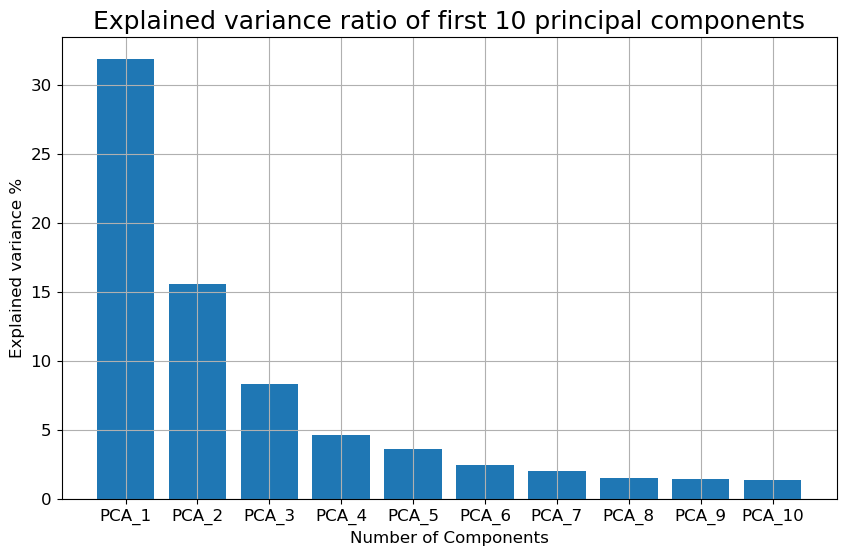

In [18]:
explained_var = pca.explained_variance_ratio_*100    # multiplying the pc's by 100 to get %

plt.figure(figsize=(10,6))                          # creating a figure image
plt.grid()                                           # adding background grid to plot
plt.bar(x=[f"PCA_{x}" for x in range(1, NUM_PC+1)], height=explained_var)   # creating a bar plot with PCA_1, PCA_2... on x and PCA's on yaxis
plt.xlabel('Number of Components', size=12)
plt.xticks(fontsize=12)
plt.ylabel('Explained variance %', size=12)
plt.yticks(fontsize=12)
plt.title('Explained variance ratio of first 10 principal components', size=18)
plt.show()

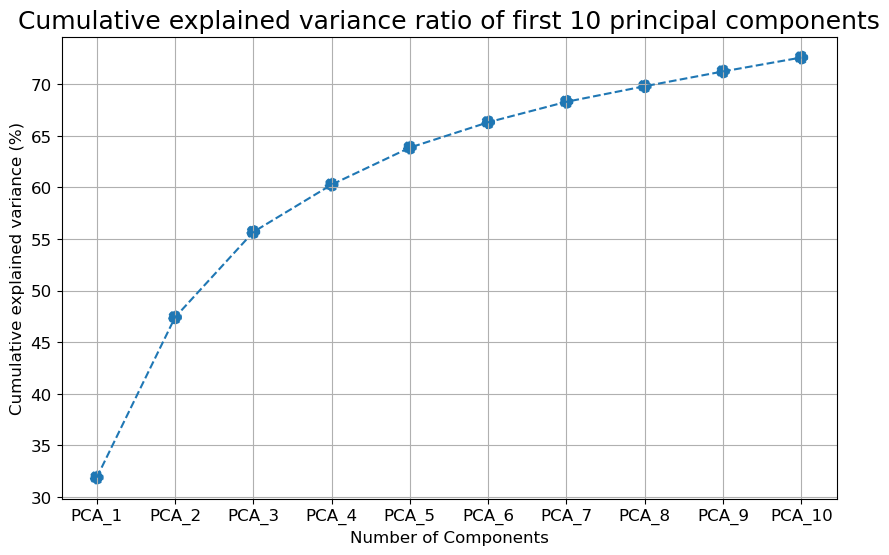

In [19]:
plt.figure(figsize = (10, 6))
plt.grid()
cum_variance = np.cumsum(explained_var)             # taking the cumulative sum of the principal components
plt.scatter([f"PCA_{x}" for x in range(1, NUM_PC+1)], cum_variance, linestyle='--', s=80)       # adding each pc as a dot in plot
plt.plot([f"PCA_{x}" for x in range(1, NUM_PC+1)], cum_variance, linestyle='--')                # connecting dots by line
plt.xlabel('Number of Components', size=12)
plt.xticks(fontsize=12)
plt.ylabel('Cumulative explained variance (%)', size=12)
plt.yticks(fontsize=12)
plt.title('Cumulative explained variance ratio of first 10 principal components', size=18)
plt.show()

In [20]:
principal_df = pd.DataFrame(data = principal_components,            # add the first three principal components to a DataFrame
             columns = [f"PCA_{x}" for x in range(1, 11)])
final_df = pd.concat([principal_df.iloc[:,:3], y_train], axis=1)    # concat the y label and class names to DataFrame
final_df['name'] = final_df['label'].map(CLASS_NAMES)
final_df.head(10)

,PCA_1,PCA_2,PCA_3,label,name
0,1096.513404,-454.995766,1112.305979,0,T-shirt/top
1,-1146.335347,529.973144,196.757508,0,T-shirt/top
2,-415.282888,295.971458,382.967029,3,Dress
3,-181.859924,-1033.123786,32.923001,0,T-shirt/top
4,1366.597697,692.444829,-545.121495,2,Pullover
5,2462.951491,733.657890,-1046.585566,2,Pullover
6,441.808829,-413.059767,775.019526,0,T-shirt/top
7,-428.282764,-341.843325,-30.791874,1,Trousers
8,667.662324,-695.445355,740.841442,0,T-shirt/top
9,0.200342,-1048.306301,146.378416,3,Dress


## Plot the principal components for different clothing types

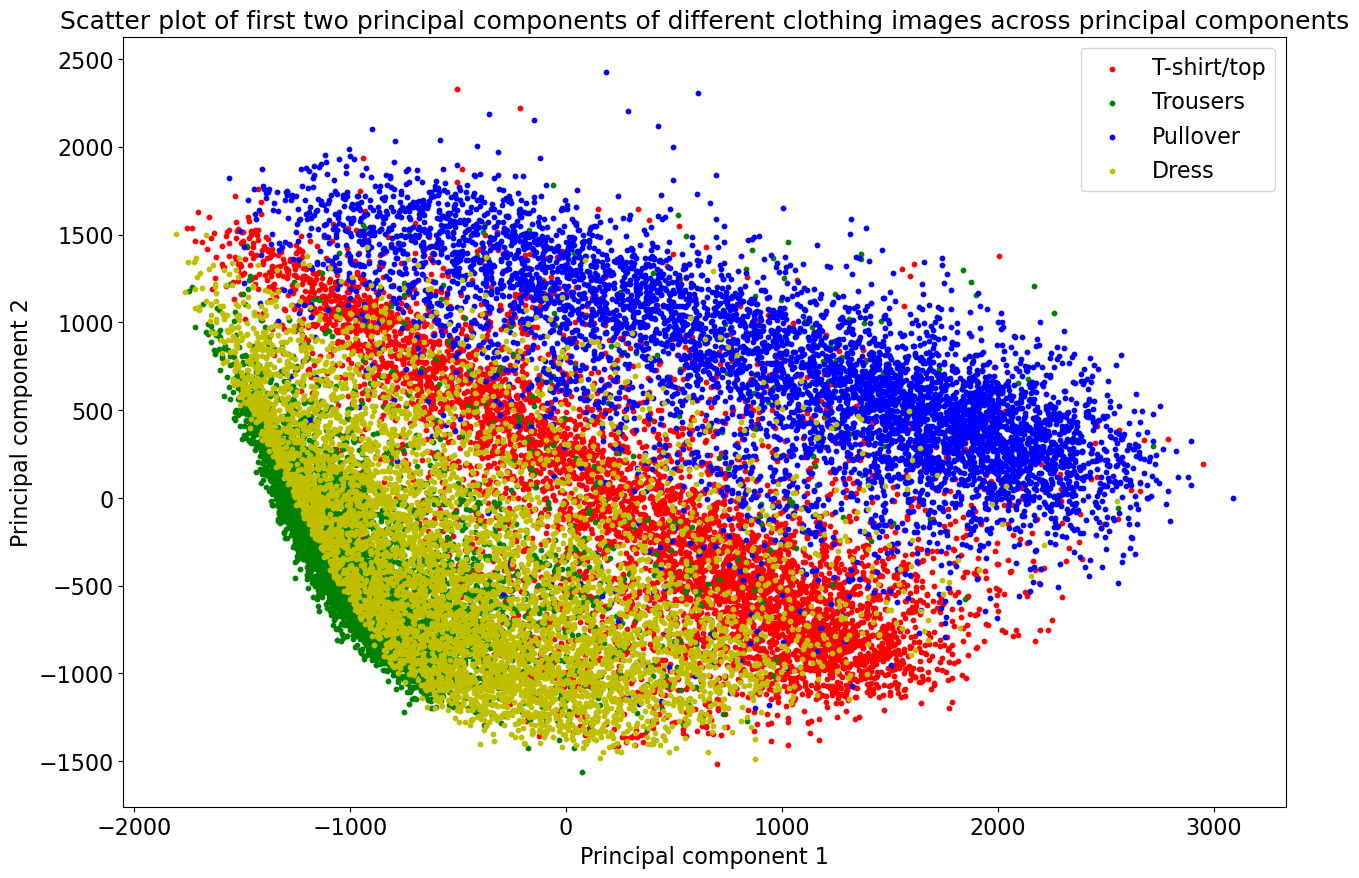

In [22]:
COLORS = ['r', 'g', 'b', 'y']                   # set initial colors red, green, blue and yellow

fig, ax = plt.subplots(figsize=(15, 10))        # create a figure and axes objects

for label, group in final_df.groupby('label'):  # looping through the dataframe,grouping data by its label
    ax.scatter(group['PCA_1'], group['PCA_2'],  # graphing a scatter plot for each label's observations and add the label name
               label=group['name'].iloc[0],     # set color from original colors list at the top from the number in label colum
               color=COLORS[label],             # i.e. label 0 = tshirt => colors list index o = red
               s=10)                            # set dot size

ax.set_xlabel('Principal component 1', size=16)
ax.set_ylabel('Principal component 2', size=16)
ax.set_title('Scatter plot of first two principal components of different clothing images across principal components', size=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)
plt.show()


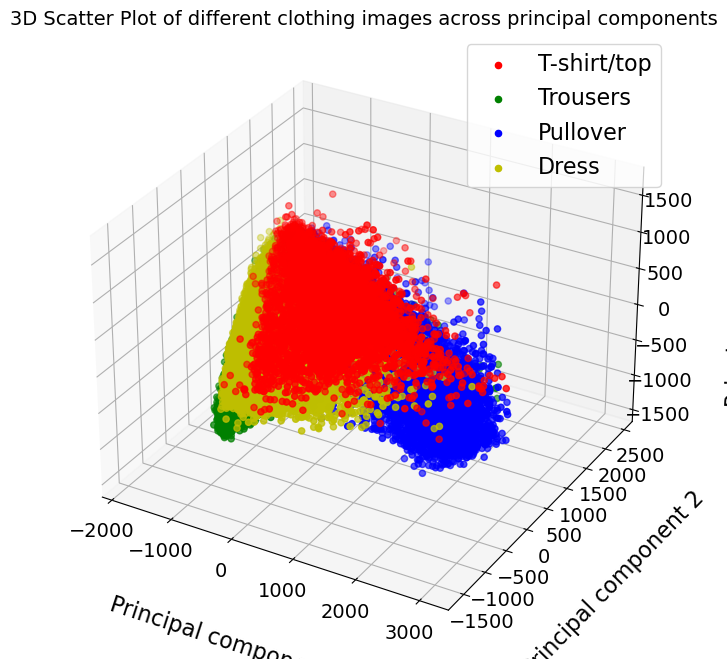

In [23]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')                   # add 3d projection

for label, group in final_df.groupby('label'):               # projecting all three PCA groups
    ax.scatter(group['PCA_1'], group['PCA_2'], group['PCA_3'], 
               label=group['name'].iloc[0], c=COLORS[label])

ax.set_xlabel('Principal component 1', size=16, labelpad=25)
ax.set_ylabel('Principal component 2', size=16, labelpad=25)
ax.set_zlabel('Principal component 3', size=16, labelpad=25)
ax.set_title('3D Scatter Plot of different clothing images across principal components', size=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16)

plt.show()

In [24]:
corr_series1 = X_train.corrwith(final_df['PCA_1'])        # calculate correlation between X_train and PCA1
corr_series2 = X_train.corrwith(final_df['PCA_2'])        # calculate correlation between X_train and PCA2
corr_series3 = X_train.corrwith(final_df['PCA_3'])        # calculate correlation between X_train and PCA3

In [25]:
NUM_COLS = 28                                                    # include corr matrix np arrays to DataFrame with 28 columns
df_corr_mat1 = pd.DataFrame(corr_series1.values.reshape(-1, NUM_COLS), columns=[f'col{i}' for i in range(NUM_COLS)])
df_corr_mat2 = pd.DataFrame(corr_series2.values.reshape(-1, NUM_COLS), columns=[f'col{i}' for i in range(NUM_COLS)])
df_corr_mat3 = pd.DataFrame(corr_series3.values.reshape(-1, NUM_COLS), columns=[f'col{i}' for i in range(NUM_COLS)])

## Correlation matrix of PCA 1 to pixel images

In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
df_corr_mat1.style.background_gradient(axis=None)

# Displaying the correlation matrix of PCA 1 to the pixel images where correlation magnitudes are shaded
# Darker colors indicate higher correlation figures

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27
0,0.004447,0.024944,0.041772,0.039646,0.035525,0.057207,0.072787,0.109343,0.154129,0.127040,-0.051407,-0.075685,-0.098838,-0.112227,-0.093802,-0.089121,-0.030096,-0.035534,-0.072985,0.091965,0.112849,0.083227,0.055162,0.031540,0.033499,0.018404,0.015227,0.007583
1,0.005207,0.012227,0.024209,0.053202,0.061626,0.116175,0.252312,0.424773,0.527000,0.491017,0.238768,0.208524,0.190240,0.107459,0.088075,0.174615,0.233243,0.252072,0.290818,0.483851,0.464764,0.304699,0.154523,0.072755,0.053756,0.030504,0.009441,0.005447
2,0.016502,0.009511,0.032091,0.065532,0.115183,0.314432,0.545795,0.679497,0.701974,0.598387,0.321805,0.315899,0.310846,0.253950,0.219628,0.310126,0.338746,0.364339,0.414186,0.638341,0.695534,0.606753,0.398480,0.184212,0.082475,0.040920,0.017740,0.006782
3,0.013396,0.020917,0.041668,0.080447,0.237410,0.489493,0.698069,0.769801,0.759831,0.601174,0.342819,0.339666,0.316897,0.293284,0.290191,0.328324,0.353753,0.394205,0.438449,0.662625,0.767856,0.735466,0.586677,0.331267,0.140354,0.054683,0.022934,0.008663
4,0.011317,0.024687,0.053963,0.128154,0.335956,0.600918,0.763600,0.819483,0.791071,0.589551,0.355493,0.357617,0.322990,0.298477,0.289030,0.321786,0.358282,0.409069,0.457308,0.676740,0.815820,0.796695,0.679149,0.443324,0.210739,0.077126,0.029494,0.004134
5,0.005136,0.020027,0.069306,0.176143,0.401951,0.665526,0.801338,0.841917,0.793859,0.557584,0.350046,0.349722,0.295992,0.271049,0.253825,0.278127,0.329737,0.386283,0.444650,0.663868,0.831396,0.832758,0.732777,0.512715,0.271153,0.106196,0.039336,0.007169
6,0.013741,0.029130,0.082053,0.218755,0.453129,0.705779,0.817273,0.845637,0.790527,0.536627,0.337967,0.323727,0.263023,0.232694,0.202022,0.217687,0.283324,0.352968,0.428627,0.650233,0.833179,0.844708,0.768856,0.560229,0.314071,0.141429,0.048328,0.015187
7,0.018041,0.038119,0.101629,0.258238,0.492152,0.737069,0.819201,0.839563,0.785158,0.534273,0.341261,0.314642,0.252382,0.234114,0.243232,0.178532,0.265126,0.344930,0.420443,0.653357,0.831185,0.845041,0.790973,0.597521,0.347053,0.174049,0.065393,0.025811
8,0.018152,0.046211,0.133408,0.291823,0.523800,0.759021,0.821162,0.827713,0.774199,0.544471,0.352876,0.322484,0.251945,0.259842,0.378555,0.165568,0.254482,0.356887,0.432383,0.667364,0.822278,0.838014,0.804315,0.628607,0.379314,0.203209,0.091414,0.023597
9,0.018935,0.056563,0.153126,0.315429,0.546738,0.768333,0.816881,0.812564,0.755115,0.565339,0.360315,0.325359,0.245951,0.294256,0.483938,0.163955,0.248660,0.356979,0.444364,0.673826,0.805296,0.826594,0.811443,0.649918,0.404503,0.228144,0.106967,0.023407


## Correlation heatmaps of principal components to pixel images

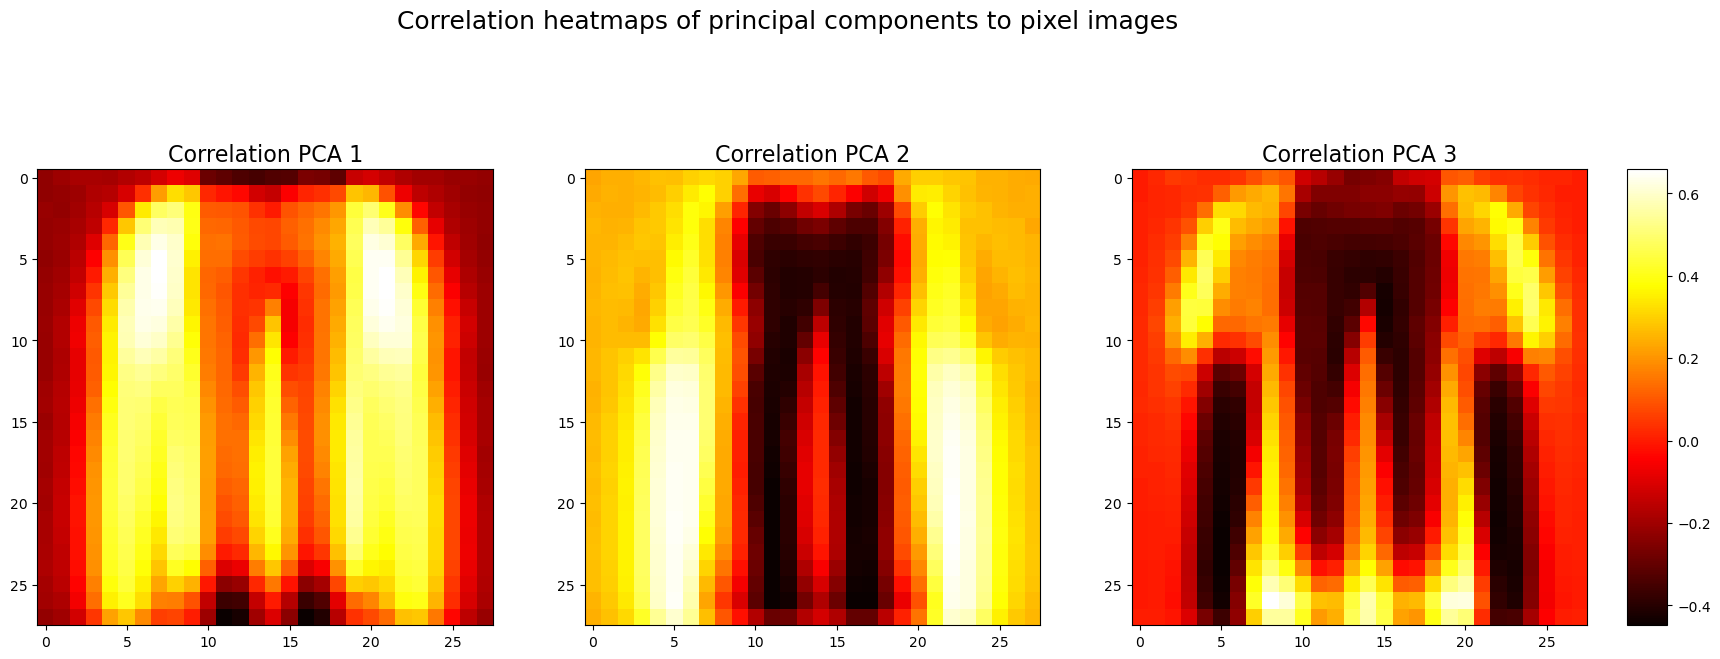

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Correlation heatmaps of principal components to pixel images', fontsize=18)
for i in range(3):
    im = axs[i].imshow(eval(f"df_corr_mat{i+1}"), cmap='hot', interpolation='nearest')
    axs[i].set_title(f'Correlation PCA {i + 1}', fontsize=16)

pos = axs[2].get_position()
cax = fig.add_axes([pos.x1 + 0.02, pos.y0, 0.02, pos.height])
cbar = plt.colorbar(im, cax=cax)

plt.show()

Conclusion:

- The first principal components explains about a third of original variance.
- Given the complexity of the data and that we have truncated 784 features to a few features, the fact that 2 principal components explain about 47% and 3 components explain about 56% of variance is fairly good.
- By using the PCA analysis we gain readability by reducing the number of features at the cost of losing some of the dataset's variance. 
- This shows that a large number of features explain very little (the more peripheral of the image pixels), i.e. they shift little in color and largely stays black.
- The more central pixel features on the other hand explain a lot of the variance, i.e. they shift more frequently in color from black to white.

- There is quite some overlaps between clothing categories in the principal component plots which means that as we have removed a significant bit of the original variance, it might be hard in some cases to deduce what clothing category a certain image belongs to.
- The pullover category overall appears most distinct among the four clothing groups.
- The correlation heatmaps show that PCA 1 is most highly correlated around the center, PCA 2 fairly negative correlation in the center and PCA 3 for example show correlation that is more varying horizontally. The pictures also display orthogonality where high correlation areas in PCA 1 to the images are generally combined with low correlation areas in PCA 2 and so on. 

### Setting up machine learning models to predict clothing types

### Random Forest classification prediction model

In [54]:
rf_classifier_base = RandomForestClassifier(random_state=42)                   # Instantiating a Random Forest Classifier object
print('Default random forest hypterparameters')
pprint(rf_classifier_base.get_params())

Default random forest hypterparameters
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [55]:
rf_classifier_base.fit(X_train, y_train)                        # Training the data using X_train features on y_train labels
rf_base_y_predicts = pd.Series(rf_classifier_base.predict(X_test))  # Model predicted values from test set features


In [56]:
df_rf_base = pd.concat([rf_base_y_predicts, y_test], axis=1)      # Creating a DataFrame with Prediction, Actual, names and accurate
df_rf_base.columns = ['Prediction', 'Actual']                   # Relabel columns
df_rf_base['Accurate'] = df_rf_base['Prediction'] == df_rf_base['Actual']  # Give True if Pred == Actual
df_rf_base['name'] = df_rf_base['Actual'].map(CLASS_NAMES)   # map Actual labels to class names
print('Output of random forest classifier on test set')
df_rf_base.head()

Output of random forest classifier on test set


,Prediction,Actual,Accurate,name
0,2,2,True,Pullover
1,1,1,True,Trousers
2,1,1,True,Trousers
3,1,1,True,Trousers
4,3,3,True,Dress


In [57]:
accurate_labels = df_rf_base.groupby('name')['Accurate'].sum() # Grouping data by its name and summing Accuracy (True=1)
accurate_percentage = accurate_labels.values/df_rf_base.groupby('name')['Accurate'].count()*100
# getting series values from accurate_labels and divide by number of observations in each label class
df_rf_base_output = pd.merge(accurate_labels,accurate_percentage, left_index=True, right_index=True)
df_rf_base_output.columns = ['Accurate labels', 'Accurate (%)']
print('Showing the number of accurate labels per clothing category:')
df_rf_base_output

Showing the number of accurate labels per clothing category:


,Accurate labels,Accurate (%)
name,,
Dress,946,94.6
Pullover,962,96.2
T-shirt/top,928,92.8
Trousers,964,96.4


### Setting up confusion matrix to display prediction results

Confusion matrix of clothing categories using Random Forest classifier with default hyperparameters


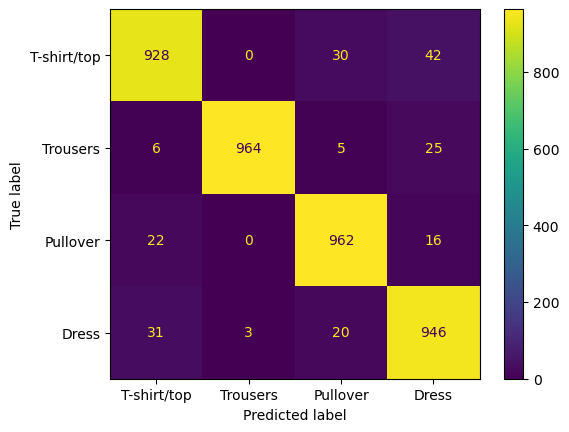

In [58]:
conf_mat_base = confusion_matrix(df_rf_base['Actual'], df_rf_base['Prediction'])   
# prettify display of matrix, using class label names
display = ConfusionMatrixDisplay(confusion_matrix=conf_mat_base,                         
                                 display_labels=[CLASS_NAMES[val] for val in rf_classifier_base.classes_])
print('Confusion matrix of clothing categories using Random Forest classifier with default hyperparameters')
display.plot(values_format='')    # remove scientific notation
plt.show()

### Classification report using Random Forest classifier with default hyperparameters

In [68]:
print('Classification report using Random Forest classifier with default hyperparameters')
print(classification_report(df_rf_base['Actual'], df_rf_base['Prediction'], 
                            target_names=[CLASS_NAMES[val] for val in rf_classifier_base.classes_]))

base_accuracy = accuracy_score(y_test, rf_base_y_predicts)
base_f1 = f1_score(y_test, rf_base_y_predicts, average='weighted')  # Use 'weighted' for multi-class problems

Classification report using Random Forest classifier with default hyperparameters
              precision    recall  f1-score   support

 T-shirt/top       0.94      0.93      0.93      1000
    Trousers       1.00      0.96      0.98      1000
    Pullover       0.95      0.96      0.95      1000
       Dress       0.92      0.95      0.93      1000

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [60]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 10, endpoint=True)] # Number of trees in random forest
max_features = ['sqrt', 'log2', None]    # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(2, 50, num = 4, endpoint=True)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = np.linspace(0.02, 0.2, 10, endpoint=True) # Minimum number of samples required to split a node
min_samples_leaf = np.linspace(0.02, 0.3, 10, endpoint=True) # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

random_grid = {'n_estimators': n_estimators,       # Create the random grid of hyperparameters
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print('Combinations of parameters that will be traversed and tested randomly')
pprint(random_grid)

Combinations of parameters that will be traversed and tested randomly
{'bootstrap': [True, False],
 'max_depth': [2, 18, 34, 50, None],
 'max_features': ['sqrt', 'log2', None],
 'min_samples_leaf': array([0.02      , 0.05111111, 0.08222222, 0.11333333, 0.14444444,
       0.17555556, 0.20666667, 0.23777778, 0.26888889, 0.3       ]),
 'min_samples_split': array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 'n_estimators': [5, 15, 26, 36, 47, 57, 68, 78, 89, 100]}


### Setting up and training 100 random forest models with 5 folds cross-validation

In [61]:
ITERATIONS = 100
CROSS_FOLD = 5
from sklearn.metrics import make_scorer, accuracy_score, f1_score

rf_random = RandomizedSearchCV(estimator = ran_forest_classifier, 
                               param_distributions = random_grid, 
                               scoring={'accuracy': make_scorer(accuracy_score), 
                                        'f1_score': make_scorer(f1_score, average='weighted')},
                               n_iter = ITERATIONS, 
                               cv = CROSS_FOLD, 
                               refit='accuracy',
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 18, 34, 50, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([0.02      , 0.05111111, 0.08222222, 0.11333333, 0.14444444,
       0.17555556, 0.20666667, 0.23777778, 0.26888889, 0.3       ]),
                                        'min_samples_split': array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
                                        'n_estimators': [5, 15, 26, 36, 47, 57,
                                                         68, 78, 89, 100]},
                   random_state=42, refit='accuracy',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1_score': make_scorer(f1_score, average=weighted)},
                   verbose=2)

### Best random forest models

In [65]:
df_rf = pd.concat([pd.DataFrame(rf_random.cv_results_["params"]),
                   pd.DataFrame(rf_random.cv_results_["mean_test_accuracy"], columns=["Accuracy"])],axis=1)
f1 = pd.Series(rf_random.cv_results_['mean_test_f1_score'])
df_rf = pd.concat([df_rf, pd.DataFrame(f1, columns=["F1"])], axis=1)
df_rf = df_rf.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print('Summary of the feature params for all random forest models, ordered by accuracy')
df_rf

Summary of the feature params for all random forest models, ordered by accuracy


,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap,Accuracy,F1
0,57,0.02,0.02,sqrt,18.0,True,0.90,0.90
1,89,0.04,0.05,log2,18.0,False,0.90,0.90
2,89,0.04,0.05,log2,34.0,False,0.90,0.90
3,26,0.10,0.02,sqrt,34.0,False,0.89,0.89
4,5,0.06,0.02,log2,NaN,False,0.89,0.89
...,...,...,...,...,...,...,...,...
95,5,0.20,0.30,sqrt,NaN,True,0.52,0.43
96,89,0.08,0.27,None,34.0,True,0.48,0.32
97,78,0.10,0.24,None,2.0,True,0.48,0.32
98,47,0.14,0.30,None,50.0,True,0.48,0.32


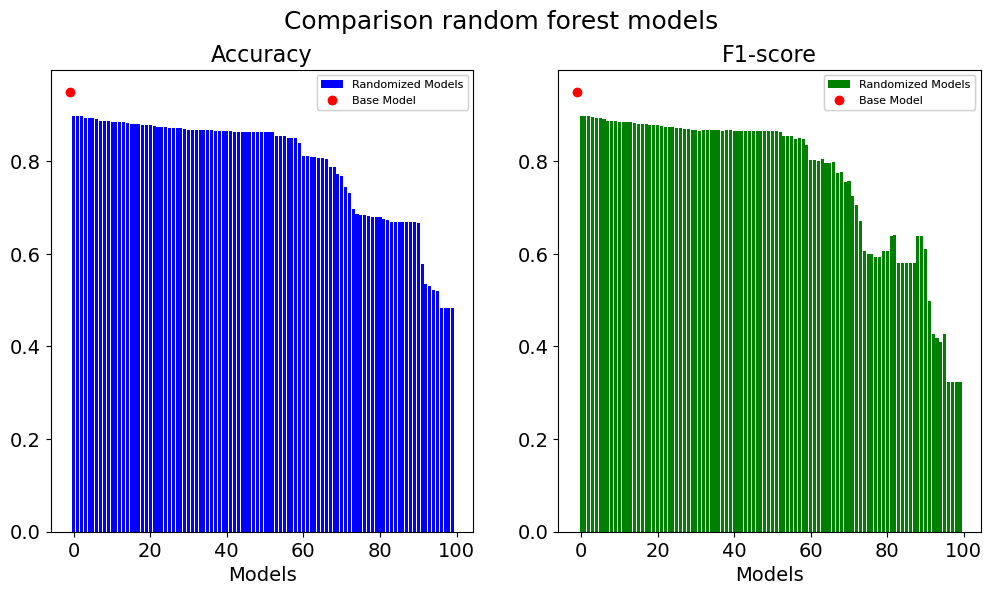

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparison random forest models', fontsize=18)
df_rf = df_rf.sort_values('Accuracy', ascending=False)
bar1 = axes[0].bar(df_rf.index, df_rf.Accuracy, color='b', label='Randomized Models')
scatter1 = axes[0].scatter(-1, base_accuracy, color='red', marker='o', label='Base Model')

axes[0].set_title('Accuracy', fontsize=16)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].set_xlabel('Models', fontsize=14)
axes[0].add_artist(axes[0].legend(handles=[bar1, scatter1], loc='upper right', prop={'size': 8}))

df_rf = df_rf.sort_values('F1', ascending=False)
bar2 = axes[1].bar(df_rf.index, df_rf.F1, color='g', label='Randomized Models')
scatter2 = axes[1].scatter(-1, base_f1, color='red', marker='o', label='Base Model')

axes[1].set_title('F1-score', fontsize=16)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].set_xlabel('Models', fontsize=14)
axes[1].add_artist(axes[1].legend(handles=[bar2, scatter2], loc='upper right', prop={'size': 8}))

plt.show()

## Training a Logistic regression model

In [72]:
log_reg_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial') # Instantiating a Log Reg Classifier object
print('Logistic regression hypterparameters')             # Since it is a multiclass problem, we instantiate specific solver and multi_class parameters
pprint(log_reg_classifier.get_params())

Logistic regression hypterparameters
{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [73]:
log_reg_classifier.fit(X_train, y_train)                        # Training the data using X_train features on y_train labels

C:\Users\Tobias\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [74]:
y_pred_logreg = pd.Series(log_reg_classifier.predict(X_test))  # Model predicted values from test set features

In [75]:
df_log_reg = pd.concat([y_pred_logreg, y_test], axis=1)      # Creating a DataFrame with Prediction, Actual, names and accurate
df_log_reg.columns = ['Prediction', 'Actual']                   # Relabel columns
df_log_reg['Accurate'] = df_log_reg['Prediction'] == df_log_reg['Actual']  # Give True if Pred == Actual
df_log_reg['name'] = df_log_reg['Actual'].map(CLASS_NAMES)   # map Actual labels to class names

In [76]:
print('Showing the number of accurate labels per clothing category:')
print(df_log_reg.groupby('name')['Accurate'].sum())               # Grouping data by its name and summing Accuracy (True=1)

Showing the number of accurate labels per clothing category:
name
Dress          876
Pullover       922
T-shirt/top    888
Trousers       956
Name: Accurate, dtype: int64


### Setting up confusion matrix to display prediction results

Confusion matrix of clothing categories using Logistic Regression classifier


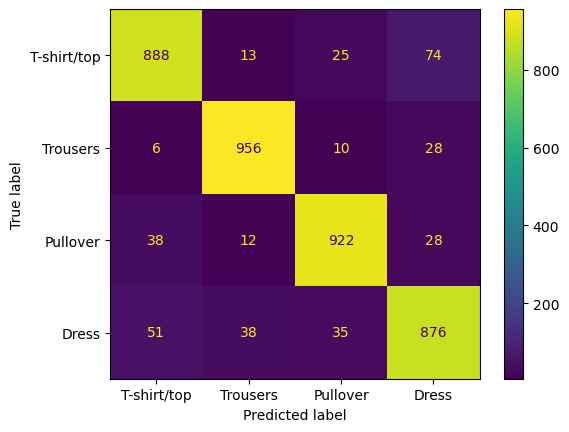

In [86]:
conf_mat_lr = confusion_matrix(df_log_reg['Actual'], df_log_reg['Prediction'])   
display = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,                         
                                display_labels=[CLASS_NAMES[val] for val in sorted(df_log_reg.Actual.unique())]
                                )
print('Confusion matrix of clothing categories using Logistic Regression classifier')
display.plot(values_format='')    # remove scientific notation
plt.show()

In [78]:
print('Classification report using Logistic Regression classifier')
print(classification_report(df_log_reg['Actual'],                # create classification repo with more summary metrics
                            df_log_reg['Prediction'], 
                            target_names=[CLASS_NAMES[val] for val in log_reg_classifier.classes_]))

Classification report using Logistic Regression classifier
              precision    recall  f1-score   support

 T-shirt/top       0.90      0.89      0.90      1000
    Trousers       0.94      0.96      0.95      1000
    Pullover       0.93      0.92      0.93      1000
       Dress       0.87      0.88      0.87      1000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



## Training an XGBoost classification model

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
xgboost_classifier = GradientBoostingClassifier(n_estimators=100, random_state=0)
xgboost_classifier.fit(X_train, y_train)                        # Training the data using X_train features on y_train labels
xgboost_y_predicts = pd.Series(xgboost_classifier.predict(X_test))  # Model predicted values from test set features
df_xgboost = pd.concat([xgboost_y_predicts, y_test], axis=1)      # Creating a DataFrame with Prediction, Actual, names and accurate
df_xgboost.columns = ['Prediction', 'Actual']                   # Relabel columns
df_xgboost['Accurate'] = df_xgboost['Prediction'] == df_xgboost['Actual']  # Give True if Pred == Actual
df_xgboost['name'] = df_xgboost['Actual'].map(CLASS_NAMES)   # map Actual labels to class names
print('Output of XG Boost classifier on test set')
df_rf_base.head()

Output of XG Boost classifier on test set


,Prediction,Actual,Accurate,name
0,2,2,True,Pullover
1,1,1,True,Trousers
2,1,1,True,Trousers
3,1,1,True,Trousers
4,3,3,True,Dress


### Setting up confusion matrix to display prediction results

Confusion matrix of clothing categories using XG Boost classifier with default hyperparameters


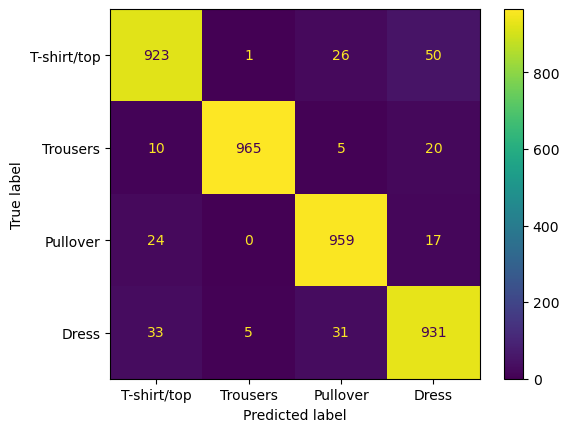

In [82]:
xg_accuracy = accuracy_score(y_test, xgboost_y_predicts)
xg_f1 = f1_score(y_test, xgboost_y_predicts, average='weighted')  # Use 'weighted' for multi-class problems
conf_mat_xgboost = confusion_matrix(df_xgboost['Actual'], df_xgboost['Prediction'])   
# prettify display of matrix, using class label names
display = ConfusionMatrixDisplay(confusion_matrix=conf_mat_xgboost,                         
                                 display_labels=[CLASS_NAMES[val] for val in xgboost_classifier.classes_])
print('Confusion matrix of clothing categories using XG Boost classifier with default hyperparameters')
display.plot(values_format='')    # remove scientific notation
plt.show()


## Machine learning model comparison

In [83]:
print(f"Random Foest model accuracy: {base_accuracy:.2f}")
print(f"Random Foest model F1-score: {base_f1:.2f}")

print(f"XG Boost model accuracy: {xg_accuracy:.2f}")
print(f"XG Boost model F1-score: {xg_f1:.2f}")

Random Foest model accuracy: 0.95
Random Foest model F1-score: 0.95
XG Boost model accuracy: 0.94
XG Boost model F1-score: 0.94


Comparison Random Forest, XG Boost, and Logistic Regression classifiers


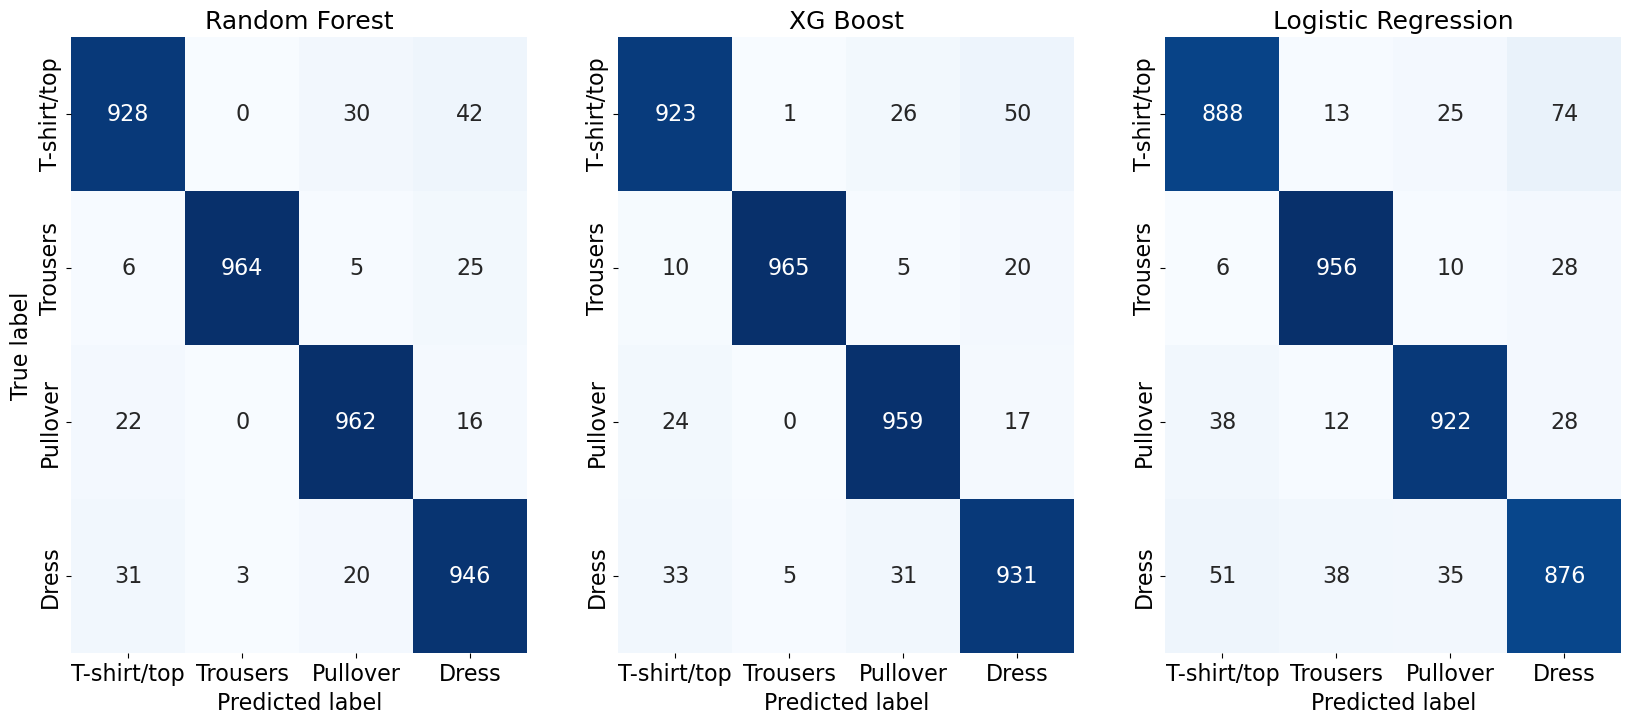

In [120]:
print('Comparison Random Forest, XG Boost, and Logistic Regression classifiers')
CLASSLABELS = {k: CLASS_NAMES[k] for k in list(CLASS_NAMES)[:4]}
class_names = [CLASSLABELS[key] for key in sorted(CLASSLABELS.keys())]
df_rf = pd.DataFrame(conf_mat_base, index=class_names, columns=class_names)
df_xg = pd.DataFrame(conf_mat_xgboost, index=class_names, columns=class_names)
df_lr = pd.DataFrame(conf_mat2, index=class_names, columns=class_names)

# Create a 1x3 grid for subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Define a common colormap
cmap = 'Blues'

# Plot the confusion matrix for Random Forest on the first subplot
sns.heatmap(df_rf, annot=True, fmt="d", ax=axes[0], 
            cmap=cmap, cbar=False, annot_kws={"size": 16})
axes[0].set_title('Random Forest', fontsize=18)
axes[0].set_xlabel('Predicted label', fontsize=16)
axes[0].set_ylabel('True label', fontsize=16)
axes[0].tick_params(axis='both', labelsize=16)

# Set tick sizes and annotation text sizes for the first subplot

# Plot the confusion matrix for XG Boost on the second subplot
sns.heatmap(df_xg, annot=True, fmt="d", ax=axes[1], 
            cmap=cmap, cbar=False, annot_kws={"size": 16})
axes[1].set_title('XG Boost', fontsize=18)
axes[1].set_xlabel('Predicted label', fontsize=16)
axes[1].tick_params(axis='both', labelsize=16)

# Set tick sizes and annotation text sizes for the second subplot

# Plot the confusion matrix for Logistic Regression on the third subplot
sns.heatmap(df_lr, annot=True, fmt="d", ax=axes[2], 
            cmap=cmap, cbar=False, annot_kws={"size": 16})
axes[2].set_title('Logistic Regression', fontsize=18)
axes[2].set_xlabel('Predicted label', fontsize=16)
axes[2].tick_params(axis='both', labelsize=16)

# Set tick sizes and annotation text sizes for the third subplot

plt.show()

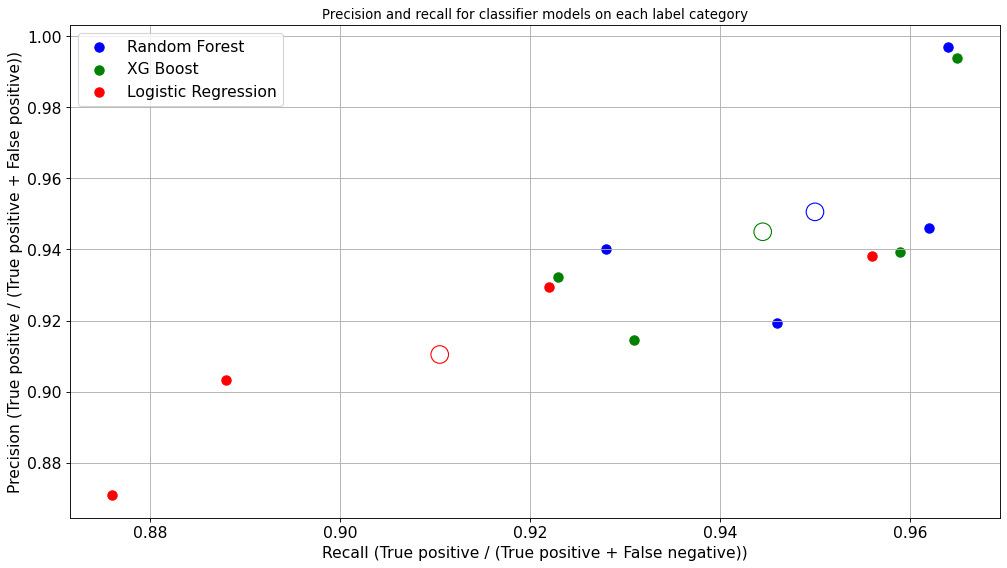

In [88]:
rf_recall = np.diag(conf_mat_base) / np.sum(conf_mat_base, axis=1)
rf_recall_mean = rf_recall.mean()
rf_accuracy = np.sum(conf_mat_base.diagonal()) / conf_mat_base.sum(axis=1)
rf_precision = np.diag(conf_mat_base) / np.sum(conf_mat_base, axis=0)
rf_precision_mean = rf_precision.mean()

xg_recall = np.diag(conf_mat_xgboost) / np.sum(conf_mat_xgboost, axis=1)
xg_recall_mean = xg_recall.mean()
xg_accuracy = np.sum(conf_mat_xgboost.diagonal()) / conf_mat_xgboost.sum(axis=1)
xg_precision = np.diag(conf_mat_xgboost) / np.sum(conf_mat_xgboost, axis=0)
xg_precision_mean = xg_precision.mean()

lr_recall = np.diag(conf_mat_lr) / np.sum(conf_mat_lr, axis=1)
lr_recall_mean = lr_recall.mean()
lr_accuracy = np.sum(conf_mat_lr.diagonal()) / conf_mat_lr.sum(axis=1)
lr_precision = np.diag(conf_mat_lr) / np.sum(conf_mat_lr, axis=0)
lr_precision_mean = lr_precision.mean()

plt.figure(figsize=(15, 8), dpi=80)
plt.title('Precision and recall for classifier models on each label category')
plt.scatter(rf_recall, rf_precision, color='b', label='Random Forest', s=70)
plt.scatter(rf_recall_mean, rf_precision_mean, facecolors='none', edgecolor='b', s=250)
plt.scatter(xg_recall, xg_precision, color='g', label='XG Boost', s=70)
plt.scatter(xg_recall_mean, xg_precision_mean, facecolors='none', edgecolor='g', s=250)
plt.scatter(lr_recall, lr_precision, color='r', label='Logistic Regression', s=70)
plt.scatter(lr_recall_mean, lr_precision_mean, facecolors='none', edgecolor='r', s=250)

plt.ylabel('Precision (True positive / (True positive + False positive))', fontsize=14)
plt.xlabel('Recall (True positive / (True positive + False negative))', fontsize=14)
plt.yticks(size=14)
plt.xticks(size=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

Conclusion: Overall the random forest classifier model performs the best with the highest accuracy and average precision and recall. XG Boost has a slightly worse precision and recall whereas the logistic regression model performs the worst.

In [92]:
y_proba_rf = rf_classifier_base.predict_proba(X_test)
y_proba_xg = xgboost_classifier.predict_proba(X_test)
y_proba_lr = log_reg_classifier.predict_proba(X_test)
test_y = pd.get_dummies(y_test,prefix='',prefix_sep='').max(level=0,axis=1)

C:\Users\Tobias\AppData\Local\Temp\ipykernel_3848\2146995697.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  test_y = pd.get_dummies(y_test,prefix='',prefix_sep='').max(level=0,axis=1)


## Training a deep learning classification model using neural networks

In [102]:
X_train_nn = X_train.values.reshape(24000,28,28) #reshape data back to 3d np array
y_train_nn = y_train.values
X_test_nn = X_test.values.reshape(4000,28,28)
y_test_nn = y_test.values

X_v = X_train_nn[20000:] / 255.0 # validation set of last 4000 images, scaled
X_t = X_train_nn[:20000] / 255.0 # train set of first 20000 images, scaled 
y_v = y_train_nn[20000:] # validation set of last 4000 images
y_t = y_train_nn[:20000] # train set of first 20000 images

X_test_scaled = X_test_nn / 255.0
# scaling X_test data

In [103]:
def plot_learning_curve(model_results,title):
    fig, ax1 = plt.subplots(figsize=(16,8))
    ax1.plot(model_results.index, model_results['accuracy'],
        label='Training accuracy',color='blue')
    ax1.plot(model_results.index, model_results['val_accuracy'],
        label='Validation accuracy',color='green')
    ax1.set_xlabel('Number of epochs',fontsize=14)
    ax1.set_ylabel('Accuracy (%)', fontsize=14)
    ax1.tick_params(axis='both',which='both',labelsize=14)

    ax2=ax1.twinx()

    ax2.plot(model_results.index, model_results['loss'],
        label='Training loss', color='red')
    ax2.plot(model_results.index, model_results['val_loss'],
        label='Validation loss', color='gold')
    ax2.set_xlabel('Number of epochs',fontsize=14)
    ax2.set_ylabel('Loss',fontsize=14)
    ax2.tick_params(axis='both',which='both',labelsize=14)

    ax1.set_title(title,fontsize=16)
    lines1,labels1=ax1.get_legend_handles_labels()
    ax1.legend(lines1,labels1,loc='lower left',fontsize=14)
    lines2,labels2=ax2.get_legend_handles_labels()
    ax2.legend(lines2,labels2,loc='lower right',fontsize=14)
    plt.grid(True)
    plt.gca().set_ylim(0,3)
    return fig, ax1, ax2

In [105]:
from keras.layers import Dense, Activation, Flatten
model1 = Sequential() # instantiating a sequential neural network moel
model1.add(Flatten(input_shape=(28,28))) # add first input layer in 28x28 shape
model1.add(Dense(300, activation="relu")) # add hidden layer of 300 neurons with ReLu
model1.add(Dense(100, activation="relu")) # add second hidden layer of 100 neurons wit
model1.add(Dense(4, activation="softmax")) # add output layer of 4 neurons (same as c
model1.summary() #softmax activation in output is appropriate in classifier neural ne

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 266,004
Trainable params: 266,004
Non-trainable params: 0
_________________________________________________________________


In [106]:
# compile model given loss and optimizer functions
model1.compile(loss="sparse_categorical_crossentropy",
                optimizer="sgd",
                metrics=["accuracy"])
# SGD = stochastic gradient descent, computes the gradient of the network loss function
# with respect to each individual weight in the network.
# The model uses each of the gradients multiplied by a certain learning rate, to determine the speed of move 
# the direction the gradient is pointing.

In [107]:
history1 = model1.fit(X_t,y_t, # fit model on training set with 200 epochs (rounds of t
                      epochs=200,
                      validation_data=(X_v,y_v))

Epoch 1/200
625/625 [==============================] - 5s 5ms/step - loss: 0.3587 - accuracy: 0.8990 - val_loss: 0.2558 - val_accuracy: 0.9165
Epoch 2/200
625/625 [==============================] - 2s 4ms/step - loss: 0.2355 - accuracy: 0.9255 - val_loss: 0.2327 - val_accuracy: 0.9252
Epoch 3/200
625/625 [==============================] - 2s 4ms/step - loss: 0.2139 - accuracy: 0.9312 - val_loss: 0.2288 - val_accuracy: 0.9287
Epoch 4/200
625/625 [==============================] - 2s 4ms/step - loss: 0.2013 - accuracy: 0.9358 - val_loss: 0.2192 - val_accuracy: 0.9277
Epoch 5/200
625/625 [==============================] - 2s 4ms/step - loss: 0.1917 - accuracy: 0.9390 - val_loss: 0.2054 - val_accuracy: 0.9352
Epoch 6/200
625/625 [==============================] - 2s 4ms/step - loss: 0.1848 - accuracy: 0.9402 - val_loss: 0.1988 - val_accuracy: 0.9385
Epoch 7/200
625/625 [==============================] - 2s 4ms/step - loss: 0.1791 - accuracy: 0.9428 - val_loss: 0.1976 - val_accuracy: 0.9370

Epoch 58/200
625/625 [==============================] - 2s 4ms/step - loss: 0.0515 - accuracy: 0.9846 - val_loss: 0.1550 - val_accuracy: 0.9473
Epoch 59/200
625/625 [==============================] - 2s 4ms/step - loss: 0.0506 - accuracy: 0.9850 - val_loss: 0.1500 - val_accuracy: 0.9488
Epoch 60/200
625/625 [==============================] - 2s 4ms/step - loss: 0.0494 - accuracy: 0.9858 - val_loss: 0.1443 - val_accuracy: 0.9515
Epoch 61/200
625/625 [==============================] - 2s 4ms/step - loss: 0.0483 - accuracy: 0.9849 - val_loss: 0.1436 - val_accuracy: 0.9523
Epoch 62/200
625/625 [==============================] - 2s 4ms/step - loss: 0.0472 - accuracy: 0.9865 - val_loss: 0.1453 - val_accuracy: 0.9545
Epoch 63/200
625/625 [==============================] - 2s 4ms/step - loss: 0.0455 - accuracy: 0.9872 - val_loss: 0.1505 - val_accuracy: 0.9525
Epoch 64/200
625/625 [==============================] - 2s 4ms/step - loss: 0.0451 - accuracy: 0.9873 - val_loss: 0.1532 - val_accuracy:

Epoch 115/200
625/625 [==============================] - 3s 4ms/step - loss: 0.0108 - accuracy: 0.9980 - val_loss: 0.1871 - val_accuracy: 0.9532
Epoch 116/200
625/625 [==============================] - 3s 4ms/step - loss: 0.0109 - accuracy: 0.9979 - val_loss: 0.1890 - val_accuracy: 0.9513
Epoch 117/200
625/625 [==============================] - 3s 4ms/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 0.1910 - val_accuracy: 0.9520
Epoch 118/200
625/625 [==============================] - 2s 4ms/step - loss: 0.0101 - accuracy: 0.9986 - val_loss: 0.1942 - val_accuracy: 0.9523
Epoch 119/200
625/625 [==============================] - 2s 4ms/step - loss: 0.0084 - accuracy: 0.9990 - val_loss: 0.1900 - val_accuracy: 0.9530
Epoch 120/200
625/625 [==============================] - 3s 4ms/step - loss: 0.0085 - accuracy: 0.9987 - val_loss: 0.1956 - val_accuracy: 0.9513
Epoch 121/200
625/625 [==============================] - 3s 4ms/step - loss: 0.0092 - accuracy: 0.9984 - val_loss: 0.1909 - val_ac

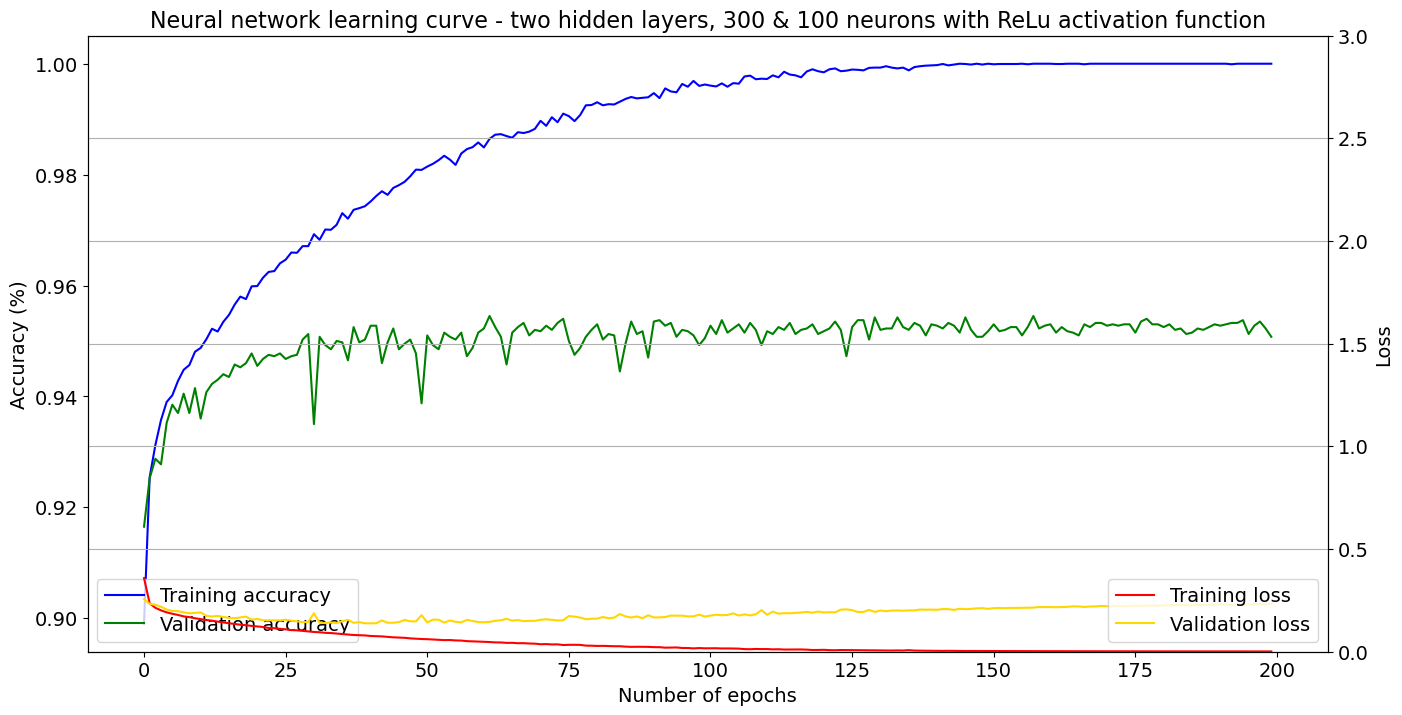

In [109]:
model1_results = pd.DataFrame(history1.history)

plot_learning_curve(model1_results, title=
"Neural network learning curve - two hidden layers, 300 & 100 neurons with ReLu activation function")
plt.show()

Conclusion: The model shows that training accuracy gradually increases and training loss gradually decreases with a very good fit. 
This is generally a steady trend that we like to see. The model does not learn much more when training accuracy plateus and 
becomes horizontal, which happens after about 140 epochs.

On the validation data set, the accuracy increases strongly in the first 25 epochs and steadies at about 95%, which is a decent accuracy for validation data. Meanwhile, the validation loss declines initially but after around 75 epochs gradually and mildly increases.